# **Custom Transformer**

In [ ]:
import random
import os

SEED = 32
random.seed(SEED)

import numpy as np 
import pandas as pd
import spacy

from sklearn.metrics import accuracy_score
from sklearn.metrics import  f1_score

from torch import nn
import torch
from torchtext import data
from torch.nn  import functional as F
import torch.optim as  optim 
import dill as dill

if torch.cuda.is_available():  
  dev = "cuda:0" 
  print("gpu up")
else:  
  dev = "cpu"  
device = torch.device(dev)



In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv


In [4]:
#breaking data into train and test
from sklearn.model_selection import train_test_split

labeled_dataframe = pd.read_csv('/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv')
labeled_dataframe.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
#split 
from pathlib import Path
traindata, test = train_test_split(labeled_dataframe, test_size=0.2)

In [6]:
"""

those are the libraries I use for processing text

"""

import nltk
nltk.download("punkt")

import re
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()

tokenizer = Tokenizer(nlp.vocab)

from nltk import word_tokenize,sent_tokenize
from nltk.stem  import PorterStemmer


from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
stops = stopwords.words("english")


def removepunc(my_str): # function to remove punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char
    return no_punct

def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))
snowstem = SnowballStemmer("english")
portstem = PorterStemmer()


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
#traindata = toxic_train_df #pd.read_csv("/kaggle/input/hate-speech-detection/toxic_train.csv")
#test = toxic_test_df #pd.read_csv("/kaggle/input/hate-speech-detection/toxic_test.csv")
traindata.drop("Unnamed: 0",axis=1,inplace=True)
test.drop("Unnamed: 0",axis=1,inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
"""
this function is the tokenizer we are using, it does basic processing also  like ,
Lowercase the text
removing punctuation, stop words and numbers,
it also removes extra spaces and unwanted characters (I use regex for that)


before using the tokenizer I was testing it on the train dataframe manually  
"""

def myTokenizer(x):
 return  [snowstem.stem(word.text)for word in 
          tokenizer(removepunc(re.sub(r"\s+\s+"," ",re.sub(r"[^A-Za-z0-9()!?@\'\`\"\r+\r+\n+\n+\b+]"," ",x.lower()))).strip()) 
          if (word.text not in stops and not hasNumbers(word.text)) ]

# myTokenizer = data.get_tokenizer("basic_english")


In [9]:
"""
here I'm using the torchtext fields and dataset classes they can ease the work to get
the dataset ready for the pytorch model

the class DataFrameDataset is the easiest way I found to turn a dataframe into a torchtext dataset

this cell will take sometime to finish
"""

TEXT = data.Field(tokenize=myTokenizer,batch_first=True,fix_length=140)
LABEL = data.LabelField(dtype=torch.float ,batch_first=True)


class DataFrameDataset(data.Dataset):

    def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
        fields = [('comment_text', text_field), ('toxic', label_field)]
        examples = []
        for i, row in df.iterrows():
            if row['class'] == 2:
                label = 0
            else:
                label = 1
                
            text = row['tweet']
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)
  

torchdataset = DataFrameDataset(traindata, TEXT,LABEL)
torchtest = DataFrameDataset(test, TEXT,LABEL)

In [10]:
train_data, valid_data = torchdataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [11]:
"""
this cell build the vocab which means it get all the used words and if also ignores any word 
that only appeared less than 3 times
"""
TEXT.build_vocab(train_data,min_freq=3)  
LABEL.build_vocab(train_data)


In [12]:
#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

print(len(TEXT.vocab))


Size of TEXT vocabulary: 4941
Size of LABEL vocabulary: 2
[('bitch', 7347), ('rt', 4915), ('hoe', 2765), ('co', 1934), ('http', 1867), ('like', 1804), ('fuck', 1473), ('pussi', 1428), ('im', 1338), ('nigga', 1250)]
4941


In [13]:
#set batch size
BATCH_SIZE = 128

"""
we are using batches for validation and test set because of memory usage we can't pass the whole set at once 
"""


train_iterator,valid_iterator,test_iterator= data.BucketIterator.splits(
    (train_data,valid_data,torchtest), 
    batch_size = BATCH_SIZE,
    device = device,
    sort =False,
shuffle=False)


In [14]:

"""
one major point here is that I encoded the embeddings in a different way 
I made an embedding layer for the position then I concatenated position embeddings with the word embeddings 
just thought it could be a usefull way to encode the positions 

had to reshape the output of the transformer layer to get the prediction
"""
class TextTransformer(nn.Module):
  def __init__(self):
    super(TextTransformer,self).__init__()
    self.wordEmbeddings = nn.Embedding(len(TEXT.vocab),140)
    self.positionEmbeddings = nn.Embedding(140,20)
    self.transformerLayer = nn.TransformerEncoderLayer(160,8) 
    self.linear1 = nn.Linear(160,  64)
    self.linear2 = nn.Linear(64,  1)
    self.linear3 = nn.Linear(140,  16)
    self.linear4 = nn.Linear(16,  1)
  def forward(self,x):
    positions = (torch.arange(0,140).reshape(1,140) + torch.zeros(x.shape[0],140)).to(device) 
    # broadcasting the tensor of positions 
    sentence = torch.cat((self.wordEmbeddings(x.long()),self.positionEmbeddings(positions.long())),axis=2)
    attended = self.transformerLayer(sentence)
    linear1 = F.relu(self.linear1(attended))
    linear2 = F.relu(self.linear2(linear1))
    linear2 = linear2.view(-1,140) # reshaping the layer as the transformer outputs a 2d tensor (or 3d considering the batch size)
    linear3 = F.relu(self.linear3(linear2))
    out = torch.sigmoid(self.linear4(linear3))
    return out

myTransformer = TextTransformer()
myTransformer.to(device)

    


TextTransformer(
  (wordEmbeddings): Embedding(4941, 140)
  (positionEmbeddings): Embedding(140, 20)
  (transformerLayer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): Linear(in_features=160, out_features=160, bias=True)
    )
    (linear1): Linear(in_features=160, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=160, bias=True)
    (norm1): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (linear1): Linear(in_features=160, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=1, bias=True)
  (linear3): Linear(in_features=140, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=1, bias=True)
)

In [15]:
def calculateMetrics(ypred,ytrue):
  acc  = accuracy_score(ytrue,ypred)
  f1  = f1_score(ytrue,ypred)
  f1_average  = f1_score(ytrue,ypred,average="macro")
  return " f1 score: "+str(round(f1,3))+" f1 average: "+str(round(f1_average,3))+" accuracy: "+str(round(acc,3))
  

Epoch 1/15: Train Loss: 0.4701 | Train Acc: 0.8005 || Val Loss: 0.4332 | Val Acc: 0.8373
Epoch 2/15: Train Loss: 0.4376 | Train Acc: 0.8312 || Val Loss: 0.4244 | Val Acc: 0.8373
Epoch 3/15: Train Loss: 0.4265 | Train Acc: 0.8312 || Val Loss: 0.4141 | Val Acc: 0.8373
Epoch 4/15: Train Loss: 0.4129 | Train Acc: 0.8312 || Val Loss: 0.4025 | Val Acc: 0.8373
Epoch 5/15: Train Loss: 0.3975 | Train Acc: 0.8313 || Val Loss: 0.3892 | Val Acc: 0.8373
Epoch 6/15: Train Loss: 0.3795 | Train Acc: 0.8325 || Val Loss: 0.3740 | Val Acc: 0.8388
Epoch 7/15: Train Loss: 0.3604 | Train Acc: 0.8375 || Val Loss: 0.3593 | Val Acc: 0.8467
Epoch 8/15: Train Loss: 0.3409 | Train Acc: 0.8463 || Val Loss: 0.3467 | Val Acc: 0.8555
Epoch 9/15: Train Loss: 0.3232 | Train Acc: 0.8557 || Val Loss: 0.3353 | Val Acc: 0.8567
Epoch 10/15: Train Loss: 0.3079 | Train Acc: 0.8651 || Val Loss: 0.3264 | Val Acc: 0.8605
Epoch 11/15: Train Loss: 0.2941 | Train Acc: 0.8722 || Val Loss: 0.3184 | Val Acc: 0.8600
Epoch 12/15: Train 

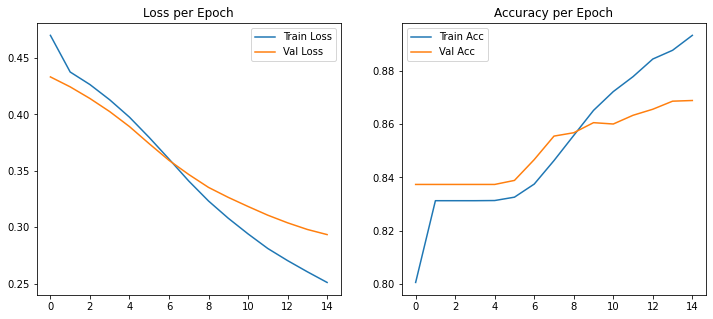

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

optimizer = optim.Adagrad(myTransformer.parameters(),lr = 0.001)

# ---- Initialize metric lists ----
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

EPOCHS = 15

for epoch in range(EPOCHS):
    # --- Training ---
    trainpreds = torch.tensor([]).to("cpu")
    traintrues = torch.tensor([]).to("cpu")
    myTransformer.train()
    epoch_loss = 0
    for batch in train_iterator:
        X = batch.comment_text
        y = batch.toxic.float()  # ensure float for BCE
        myTransformer.zero_grad()
        pred = myTransformer(X).squeeze()
        loss = F.binary_cross_entropy(pred, y)
        loss.backward()
        optimizer.step()
        trainpreds = torch.cat((trainpreds, pred.cpu().detach()))
        traintrues = torch.cat((traintrues, y.cpu().detach()))
        epoch_loss += loss.item()
    train_loss = epoch_loss / len(train_iterator)
    train_acc = accuracy_score(torch.round(trainpreds).numpy(), traintrues.numpy())
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # --- Validation ---
    valpreds = torch.tensor([]).to("cpu")
    valtrues = torch.tensor([]).to("cpu")
    myTransformer.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in valid_iterator:
            X = batch.comment_text
            y = batch.toxic.float()
            pred = myTransformer(X).squeeze().cpu()
            valpreds = torch.cat((valpreds, pred))
            valtrues = torch.cat((valtrues, y.cpu()))
            loss = F.binary_cross_entropy(pred, y.cpu())
            val_loss += loss.item()
    val_loss = val_loss / len(valid_iterator)
    val_acc = accuracy_score(torch.round(valpreds).numpy(), valtrues.numpy())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # --- Print epoch summary ---
    print(f"Epoch {epoch+1}/{EPOCHS}: "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} || "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")



# ---- Plot Curves ----
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title("Loss per Epoch")
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend(); plt.title("Accuracy per Epoch")
plt.show()
